In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

import optax

sns.set_style("darkgrid")

## Experiment Params

In [3]:
DIST_DIM = 100 # Dimension of a Gaussian
N_CHAINS = 10 # Number of parallel chains for MCMC estimates
MCMC_N_RUNS = 1000 # Number of MCMC estimates to calculate CI
INIT_STD = 100 # std of starter points for MC

## Gaussian Mixture

In [4]:
from dist import GaussianMixture

#mixture = GaussianMixture(jnp.vstack([-10*jnp.ones((DIST_DIM), dtype=float), jnp.zeros((DIST_DIM), dtype=float), 10*jnp.ones((DIST_DIM), dtype=float)]), jnp.ones((3), dtype=float))
#mixture = GaussianMixture(jnp.vstack([-10*jnp.ones((DIST_DIM), dtype=float), jnp.zeros((DIST_DIM), dtype=float), 10*jnp.ones((DIST_DIM), dtype=float)]), jnp.ones((3), dtype=float))
mixture = GaussianMixture(jnp.vstack([10 * jnp.ones((DIST_DIM), dtype=float)]), jnp.ones((1), dtype=float))
grad_log_p = jax.jit(jax.grad(mixture.log_p))

2024-07-29 17:24:16.676380: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
rng = jax.random.PRNGKey(50)
rng, key = jax.random.split(rng)
data = mixture.sample(10000, key)

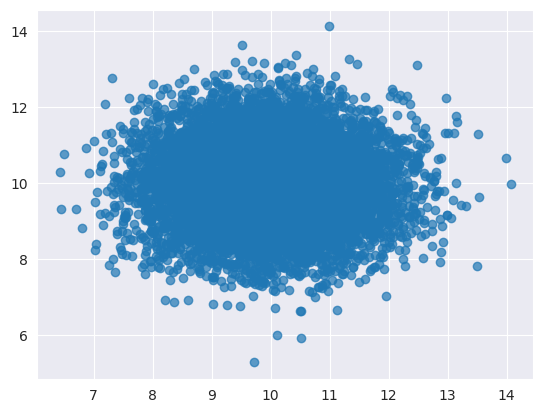

In [6]:
plt.scatter(data[:,0], data[:,1], alpha=0.7)
#plt.hist(data, bins=50, density=True)
plt.show()

## Langevin Dynamics (ULA)

In [7]:
from mcmc import LangevinDynamics, sample_multichain

In [8]:
rng, key = jax.random.split(rng)
sampler = LangevinDynamics(gradient_func=grad_log_p, n_samples=500, gamma=1e-1, burnin_steps=100)
samples = sample_multichain(sampler, DIST_DIM, key, n_chains=N_CHAINS, init_std=INIT_STD)

False


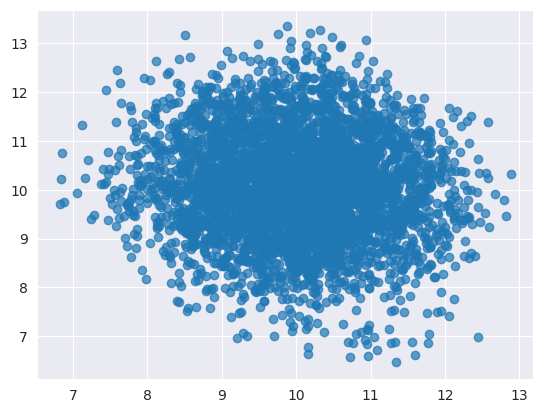

In [9]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
print(jnp.any(np.isnan(samples)))
#plt.hist(samples, bins=50, density=True)
plt.show()

## Baseline
Using a sample mean as an integral estimate

In [10]:
from mcmc import estimate_n_mcmc

In [11]:
fn = jax.jit(lambda x: x.sum(axis=-1))
true_pi = jnp.dot(mixture.coeffs, mixture.means).sum()

true_pi

Array(1000., dtype=float32)

False


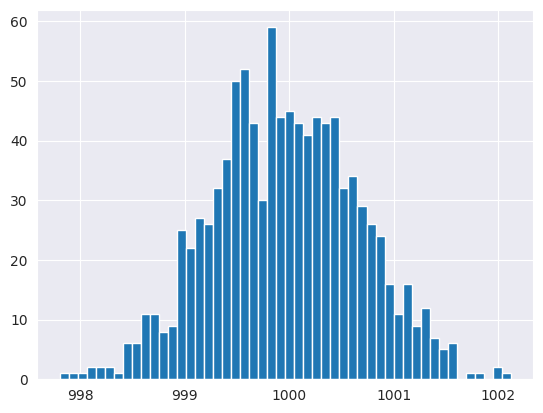

In [12]:
rng, key = jax.random.split(rng)
baseline_estimates = estimate_n_mcmc(fn, sampler, DIST_DIM, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(baseline_estimates)))
plt.hist(baseline_estimates, bins=50)
plt.show()

In [13]:
true_pi - baseline_estimates.mean(), baseline_estimates.std()

(Array(0.03997803, dtype=float32), Array(0.6994872, dtype=float32))

## Control variates (Eric's structural risk)
Train a NN with an objective from "Diffusion Approximations and Control Variates for MCMC"

In [19]:
from diffcv.cv import CVLinear, CVTrainer, CVLoss
from diffcv.logger import Logger
from diffcv.cv.data import get_data_from_sampler

In [15]:
def plot_log_results(logger: Logger):
    log_results = logger.to_pandas()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(data=log_results["learning_rate"], ax=axes[0])
    sns.lineplot(data=log_results["loss"], ax=axes[1])
    fig.show()

In [21]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(sampler, DIST_DIM, key, n_chains=100, init_std=INIT_STD)
len(dataset)

40000

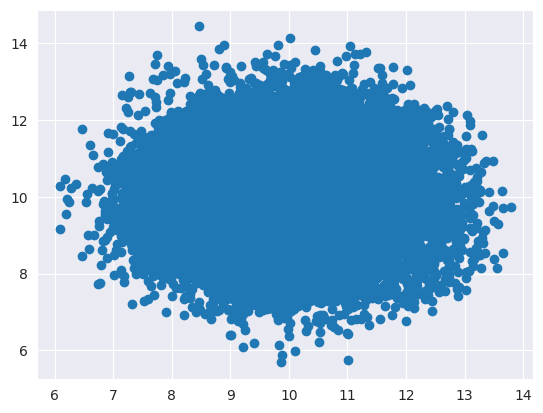

In [22]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

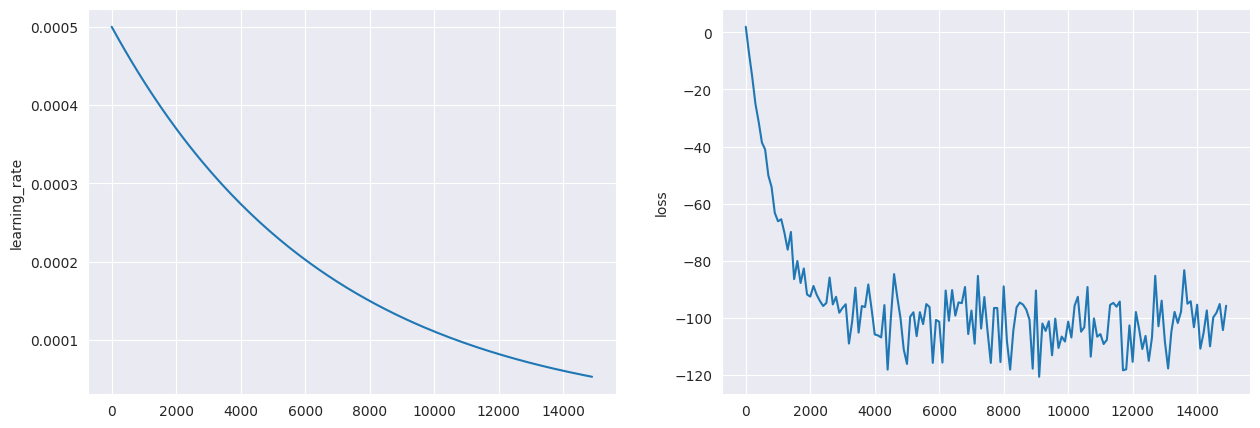

In [23]:
rng, key = jax.random.split(rng)
cv_model = CVLinear(in_size=DIST_DIM, key=key)
scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=700, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = CVLoss(fn=fn, l2_alpha=10)

logger = Logger()

cv_trainer = CVTrainer(cv_model, dataloader, optimizer, loss, logger, n_steps=15_000)

cv_trainer.train(key)

plot_log_results(logger)

In [24]:
# Check NN for nans
rng, key = jax.random.split(rng)
x = jax.random.normal(key, shape=(100, DIST_DIM))
y = jax.vmap(cv_model)(x)
print(jnp.any(jnp.isnan(y)))

False


In [25]:
from diffcv.cv import Generator

In [26]:
# Expectation of generator with respect to distribution should be 0
generator = Generator(grad_log_p, cv_model)
jax.vmap(generator)(dataset.arrays[0][:10000]).mean()

Array(-0.00227922, dtype=float32)

In [27]:
fn_with_cv = lambda x: fn(x) + generator(x)

In [28]:
# Check generator for nans
rng, key = jax.random.split(rng)
x = 1000 * jax.random.normal(key, shape=(100, DIST_DIM))
y = jax.vmap(generator)(x)
print(np.any(np.isnan(y)))

False


False


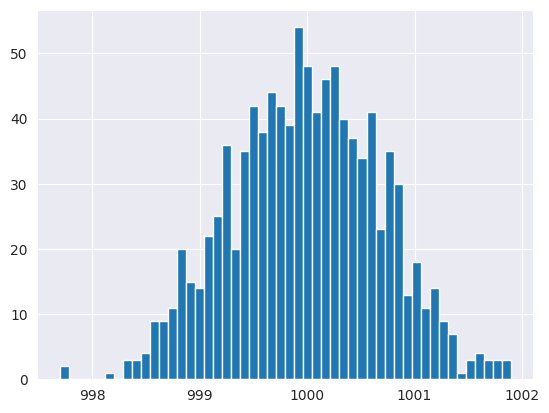

In [29]:
rng, key = jax.random.split(rng)
cv_estimates = estimate_n_mcmc(fn_with_cv, sampler, DIST_DIM, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_estimates)))
plt.hist(cv_estimates, bins=50)
plt.show()

In [30]:
true_pi - baseline_estimates.mean(), baseline_estimates.std()

(Array(0.03997803, dtype=float32), Array(0.6994872, dtype=float32))

In [31]:
true_pi - cv_estimates.mean(), cv_estimates.std()

(Array(0.01507568, dtype=float32), Array(0.69187033, dtype=float32))

## Control variates (Diff Loss)

Use Stein equation to train NN on differences between different points

In [32]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(sampler, DIST_DIM, key, n_chains=100, init_std=INIT_STD)
len(dataset)

40000

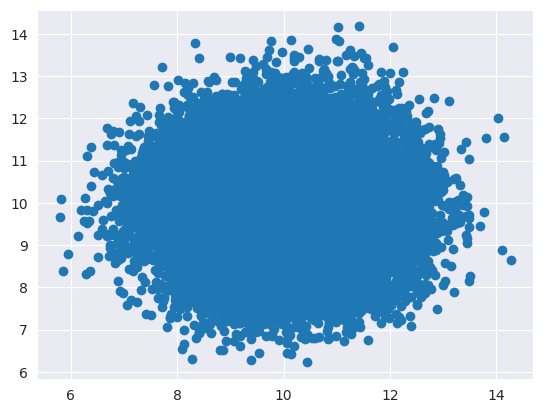

In [33]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [34]:
from diffcv.cv import DiffLoss

  0%|          | 0/5000 [00:00<?, ?it/s]

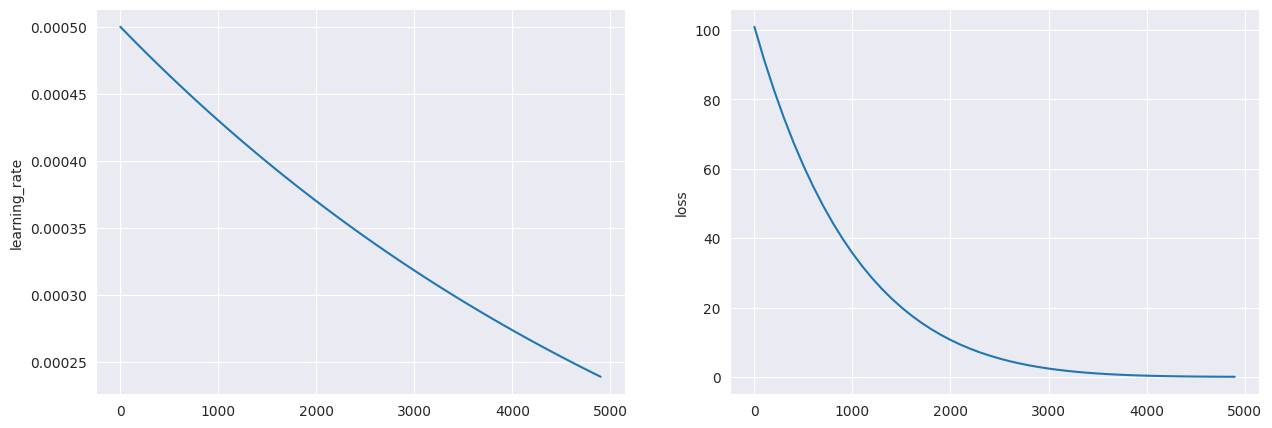

In [35]:
rng, key = jax.random.split(rng)

cv_diff_model = CVLinear(in_size=DIST_DIM, key=key)
scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=700, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = DiffLoss(fn=fn, grad_log_p=grad_log_p)

logger = Logger()

cv_diff_trainer = CVTrainer(cv_diff_model, dataloader, optimizer, loss, logger, n_steps=5_000)
cv_diff_trainer.train(key)

plot_log_results(logger)

In [36]:
generator_diff = Generator(grad_log_p, cv_diff_model)
jax.vmap(generator_diff)(dataset.arrays[0][:10000]).mean()

Array(0.01545638, dtype=float32)

In [37]:
fn_with_cv_diff = lambda x: fn(x) + generator_diff(x)

False


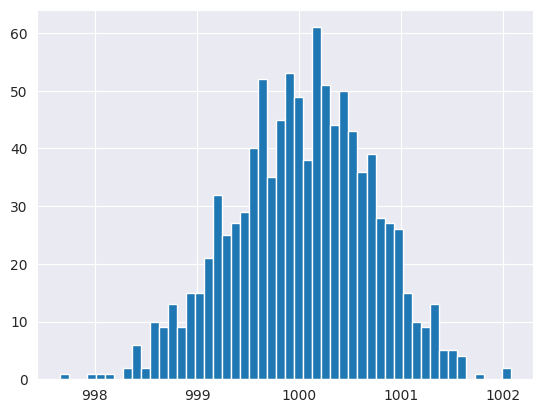

In [38]:
rng, key = jax.random.split(rng)
cv_diff_estimates = estimate_n_mcmc(fn_with_cv_diff, sampler, DIST_DIM, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_diff_estimates)))
plt.hist(cv_diff_estimates, bins=50)
plt.show()

In [39]:
true_pi - baseline_estimates.mean(), baseline_estimates.std()

(Array(0.03997803, dtype=float32), Array(0.6994872, dtype=float32))

In [40]:
true_pi - cv_estimates.mean(), cv_estimates.std()

(Array(0.01507568, dtype=float32), Array(0.69187033, dtype=float32))

In [41]:
true_pi - cv_diff_estimates.mean(), cv_diff_estimates.std()

(Array(-0.03118896, dtype=float32), Array(0.6807858, dtype=float32))

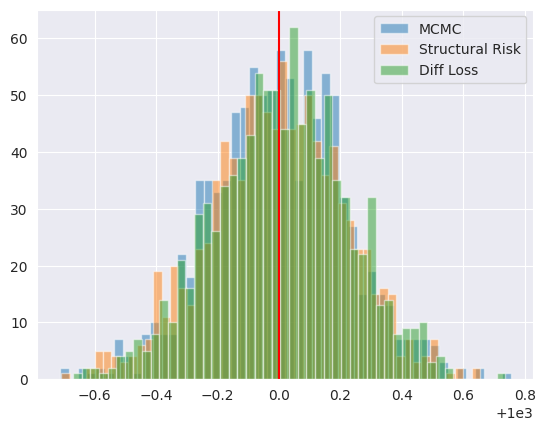

In [ ]:

plt.hist(baseline_estimates, bins=50, alpha=0.5, label="MCMC")
plt.hist(cv_estimates, bins=50, alpha=0.5, label="Structural Risk")
plt.hist(cv_diff_estimates, bins=50, alpha=0.5, label="Diff Loss")
plt.axvline(x=true_pi, color="r")
plt.legend(loc="upper right")

plt.show()